In [2]:
import math
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import datetime as dt

if 'a_api' in sys.modules:
    del sys.modules['a_api']
if 'learn' in sys.modules:
    del sys.modules['learn']
if 'util' in sys.modules:
    del sys.modules['util']

from learn import count_ngrams_plus, count_ngrams_plus_tf_idf
from a_api import TextMetrics

model_family = 'shreevastava_2021_binary'
if not os.path.exists('../../data/models/distortions/'+model_family+'/'):
    os.makedirs('../../data/models/distortions/'+model_family+'/')
for split_name in ['first_split','second_split','third_split']:
    split_path = '../../data/models/distortions/'+model_family+'/'+split_name+'/'
    if not os.path.exists(split_path):
        os.makedirs(split_path)
    
grand_t0 = dt.datetime.now()

def language_metrics(metrics_list, name_split_folder):
    metrics = {}
    for m in metrics_list:
        metrics[m] = f'../../data/models/distortions/{model_family}/{name_split_folder}/{m}.txt'
    return metrics

# Create Dataset
## Field 2530 (Shreevastava 2021) records

In [12]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"

df2 = pd.read_csv(multiclass_dataset_file_path) 
df2 = df2.drop('Id_Number', axis=1) # delete columnb with id 

df3 = df2
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


# Create training functions
### Functions for including key N-grams and creating model files

In [4]:
def ngrams_inclusion(model_ngram, ngram_inclusion_threshold):
    filtered_model_ngram = {}
    for distortion, ngram_dict in model_ngram.items():
        # Find the maximum metric value for the current distortion
        max_value = max(ngram_dict.values()) if ngram_dict else 0
        threshold_value = max_value * (ngram_inclusion_threshold / 100)

        # Filter n-grams that meet or exceed the threshold value
        filtered_model_ngram[distortion] = {
            ngram: metric for ngram, metric in ngram_dict.items() if metric >= threshold_value
        }
    return filtered_model_ngram


def create_model_files(filtered_model_ngram, name_split_folder):
    # Create .txt files for each distortion
    output_dir = f'../../data/models/distortions/{model_family}/{name_split_folder}'
    distortions_labels = []

    for distortion, ngrams in filtered_model_ngram.items():
        distortion_ = distortion.replace(" ", "_")
        file_path = f"{output_dir}/{distortion_}.txt"
        sorted_ngrams = sorted(ngrams.items(), key=lambda x: x[1], reverse=True) 
        distortions_labels.append(distortion)
        with open(file_path, "w", encoding="utf-8") as f:
            for ngram, metric_value in sorted_ngrams: 
                f.write(f"{' '.join(ngram)}\t{metric_value}\n")

    return (list(set(distortions_labels) - {'No Distortion'}))

### Evaluate functions

In [5]:
def f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_df_counts(df,evaluator,threshold, tm, debug=False):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
        ground_distortion = False if primary_distortion == 'No Distortion' else True
                       
        our_distortion = evaluator(text,threshold, tm)
        
        # https://en.wikipedia.org/wiki/F-score
        if ground_distortion == True and our_distortion == True:
            true_positive += 1
        if ground_distortion == False and our_distortion == True:
            false_positive += 1
        if ground_distortion == False and our_distortion == False:
            true_negative += 1
        if ground_distortion == True and our_distortion == False:
            false_negative += 1

        if debug:
            print(ground_distortion,our_distortion,text[:20],metrics)

    return true_positive, true_negative, false_positive, false_negative

def evaluate_df(df,evaluator,threshold,tm, debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return f1_from_counts(true_positive, true_negative, false_positive, false_negative)

def evaluate_df_acc_f1(df,evaluator,threshold,tm,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return (true_positive + true_negative) / len(df), f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def our_evaluator(text,threshold, tm):
    metrics = tm.get_sentiment_words(text)
    if metrics.get('Distortion', 0) > threshold:
        return True
    return False

### Functions for analyzing the dataset and plot heatmaps

In [6]:
def matrix_plot(row_labels, col_labels, matrix, absmax, title=None, subtitle=None, vmin=None, vmax=None, dpi=None, titlefontsize=None, subtitlefontsize=None, width=20):
    plt.rcParams["figure.figsize"] = (width, len(row_labels) / 4)
    if dpi is not None:
        plt.rcParams["figure.dpi"] = dpi

    fig, ax = plt.subplots()

    p = sns.heatmap(matrix, ax=ax, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin=-absmax if vmin is None else vmin, 
                    vmax=absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        ax.set_title(title, fontsize=titlefontsize, pad=20)

    if subtitle is not None:
        if subtitlefontsize is None:
            subtitlefontsize = round(titlefontsize * 0.7)
        ax.text(0.5, 1.01, subtitle, fontsize=subtitlefontsize, ha='center', va='bottom', transform=ax.transAxes)

    plt.show()    


def analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, df_train, df_test, name_split_folder, print_or_plot):
    
    if name_split_folder == 'first_split' and print_or_plot == 'print_results':
        print('\nN-gram selection metric:', ngram_selection_metric)
        print('N-gram max length:', ngram_max)
        print('N-gram inclusion threshold:', ngram_inclusion_threshold)

    if ngram_selection_metric == 'TF-IDF':
        model_ngram = count_ngrams_plus_tf_idf(df_train,ngram_max,binary=True, clean_punct=True)
    
    elif ngram_selection_metric in ['F','UF','FN','UFN','CFR','FCR','MR','NLMI']:
        distortions, frequency, all_n_grams, frequency_self_normalized, unique_frequency, uniq_all_n_grams, n_gram_distortions, \
        norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, unique_frequency_self_normalized, norm_norm_uniq, norm_norm_uniq_norm, \
        norm_norm_uniq_norm_norm, fcr, cfr, mr, nl_mi, N = count_ngrams_plus(df_train,ngram_max,binary=True, clean_punct=True)
        
        selection_metrics = {
            'F':frequency,
            'UF':unique_frequency,
            'FN':frequency_self_normalized,
            'UFN':unique_frequency_self_normalized,
            'CFR':cfr,
            'FCR':fcr,
            'MR':mr,
            'NLMI':nl_mi}
        
        model_ngram = selection_metrics[ngram_selection_metric]

    # Filter out values below the threshold
    filtered_model_ngram = ngrams_inclusion(model_ngram, ngram_inclusion_threshold)

    # Create .txt files for each distortion
    distortions_labels = create_model_files(filtered_model_ngram, name_split_folder)
    tm = TextMetrics(language_metrics(distortions_labels, name_split_folder), encoding = "utf-8", debug=False)

    if print_or_plot == 'print_results':
        if name_split_folder == 'first_split':
            print('\tFIRST COMBINATION')
        elif name_split_folder == 'second_split':
            print('\n\tSECOND COMBINATION')
        elif name_split_folder == 'third_split':
            print('\n\tTHIRD COMBINATION')

    if print_or_plot == 'print_results':
        print('\t\tThreshold, accuracy, F1 score:')
    any_res_acc = {}
    any_res = {}
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        acc, f1 = evaluate_df_acc_f1(df_test,our_evaluator,threshold, tm)
        any_res_acc[threshold] = acc
        any_res[threshold] = f1
        if print_or_plot == 'print_results':
            print('\t\t', threshold, acc, f1)

    return any_res_acc


# Grid search
### Perform a grid search over all hyper-parameters to determine the best combination for building the model

In [7]:
print('Full set',len(df3))
df_test = df3[df3.index % 10 == 0]
print('Test set',len(df_test))
df_tv = df3[df3.index % 10 != 0]
print('Train and valid',len(df_tv))
df_valid = df_tv[df_tv.index % 10 == 1]
print('Valid set',len(df_valid))
df_train = df_tv[(df_tv.index % 10 != 0) & (df_tv.index % 10 != 1)]
print('Train set',len(df_train))

splits = [
        (df_train, df_valid)
        #(pd.concat([part1, part2]), part3),  # (1 + 2) -> train, (3) -> test
        #(pd.concat([part1, part3]), part2),  # (1 + 3) -> train, (2) -> test
        #(pd.concat([part2, part3]), part1)   # (2 + 3) -> train, (1) -> test
]

Full set 2530
Test set 253
Train and valid 2277
Valid set 253
Train set 2024


In [14]:
def grid_search(splits):
    best_param = None
    best_acc = 0
    for ngram_selection_metric in ['TF-IDF','F','UF','FN','UFN','CFR','FCR','MR','NLMI']:
        for ngram_max in range (1, 5):
            for ngram_inclusion_threshold in [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]:
                all_values = []
                for i, (train_df, test_df) in enumerate(splits, start=1):
                    if i == 1:
                        first_split_acc_any = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'first_split', 'print_results')
                        all_values += list(first_split_acc_any.values())
                    elif i == 2:
                        second_split_acc_any = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'second_split', 'print_results')
                        all_values += list(second_split_acc_any.values())
                    elif i == 3:
                        third_split_acc_any = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'third_split', 'print_results')
                        all_values += list(third_split_acc_any.values())

                min_value = round(min(all_values),3)
                max_value = round(max(all_values),3)
                mean_value = round(np.mean(all_values),3)

                if best_acc < max_value:
                    best_acc = max_value
                    best_param = (ngram_selection_metric, ngram_max, ngram_inclusion_threshold)

                print(f"\tMin accuracy: {min_value}\tMax accuracy: {max_value}\tMean accuracy: {mean_value}\tBest accuracy: {best_acc}\tHyper-parameters: {str(best_param)}")

    print(f"Best mean accuracy: {best_acc}\tHyper-parameters: {str(best_param)}")
    return best_param

In [15]:
best_param = grid_search(splits)


N-gram selection metric: TF-IDF
N-gram max length: 1
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.383399209486166 0.36585365853658536
		 0.2 0.44664031620553357 0.3203883495145632
		 0.3 0.40711462450592883 0.17582417582417584
		 0.4 0.37549407114624506 0.08139534883720931
		 0.5 0.36363636363636365 0.04733727810650888
		 0.6 0.35177865612648224 0.012048192771084336
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.447	Mean accuracy: 0.375	Best accuracy: 0.447	Hyper-parameters: ('TF-IDF', 1, 90)

N-gram selection metric: TF-IDF
N-gram max length: 1
N-gram inclusion threshold: 80
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.383399209486166 0.36585365853658536
		 0.2 0.44664031620553357 0.3203883495145632
		 0.3 0.40711462450592883 0.17582417582417584
		 0.4 0.37549407114624506 0.08139534883720931
		 0.5 0.36363636363636365 0.0473372

		 0.9 0.35177865612648224 0.012048192771084336
	Min accuracy: 0.352	Max accuracy: 0.561	Mean accuracy: 0.456	Best accuracy: 0.652	Hyper-parameters: ('TF-IDF', 1, 0)

N-gram selection metric: TF-IDF
N-gram max length: 2
N-gram inclusion threshold: 60
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.4901185770750988 0.6522911051212937
		 0.2 0.5019762845849802 0.657608695652174
		 0.3 0.5019762845849802 0.65
		 0.4 0.5296442687747036 0.6292834890965732
		 0.5 0.5612648221343873 0.5680933852140079
		 0.6 0.43873517786561267 0.2604166666666667
		 0.7 0.37549407114624506 0.08139534883720931
		 0.8 0.35177865612648224 0.012048192771084336
		 0.9 0.35177865612648224 0.012048192771084336
	Min accuracy: 0.352	Max accuracy: 0.561	Mean accuracy: 0.456	Best accuracy: 0.652	Hyper-parameters: ('TF-IDF', 1, 0)

N-gram selection metric: TF-IDF
N-gram max length: 2
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.4901185770750988 0.652291105121293

		 0.3 0.5770750988142292 0.7249357326478149
		 0.4 0.5691699604743083 0.712401055408971
		 0.5 0.5810276679841897 0.691860465116279
		 0.6 0.6047430830039525 0.6402877697841727
		 0.7 0.4980237154150198 0.39810426540284355
		 0.8 0.41106719367588934 0.17679558011049726
		 0.9 0.3715415019762846 0.07017543859649122
	Min accuracy: 0.372	Max accuracy: 0.605	Mean accuracy: 0.527	Best accuracy: 0.652	Hyper-parameters: ('TF-IDF', 1, 0)

N-gram selection metric: TF-IDF
N-gram max length: 3
N-gram inclusion threshold: 30
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.5612648221343873 0.7175572519083969
		 0.2 0.5691699604743083 0.7212276214833758
		 0.3 0.5770750988142292 0.7249357326478149
		 0.4 0.5691699604743083 0.712401055408971
		 0.5 0.5810276679841897 0.691860465116279
		 0.6 0.6047430830039525 0.6402877697841727
		 0.7 0.4980237154150198 0.39810426540284355
		 0.8 0.41106719367588934 0.17679558011049726
		 0.9 0.3715415019762846 0.07017543859649122
	Min accuracy: 0.372	

		 0.9 0.3715415019762846 0.07017543859649122
	Min accuracy: 0.372	Max accuracy: 0.589	Mean accuracy: 0.533	Best accuracy: 0.652	Hyper-parameters: ('TF-IDF', 1, 0)

N-gram selection metric: TF-IDF
N-gram max length: 4
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.5652173913043478 0.7208121827411167
		 0.2 0.5691699604743083 0.72264631043257
		 0.3 0.5770750988142292 0.7263427109974424
		 0.4 0.5810276679841897 0.7239583333333335
		 0.5 0.5652173913043478 0.6927374301675977
		 0.6 0.5889328063241107 0.6578947368421053
		 0.7 0.5335968379446641 0.47321428571428575
		 0.8 0.4426877470355731 0.25396825396825395
		 0.9 0.3715415019762846 0.07017543859649122
	Min accuracy: 0.372	Max accuracy: 0.589	Mean accuracy: 0.533	Best accuracy: 0.652	Hyper-parameters: ('TF-IDF', 1, 0)

N-gram selection metric: TF-IDF
N-gram max length: 4
N-gram inclusion threshold: 0
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6521739130434783 0.78947368421

		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.617	Mean accuracy: 0.484	Best accuracy: 0.652	Hyper-parameters: ('TF-IDF', 1, 0)

N-gram selection metric: F
N-gram max length: 2
N-gram inclusion threshold: 80
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.5810276679841897 0.7225130890052355
		 0.2 0.616600790513834 0.738544474393531
		 0.3 0.6126482213438735 0.7183908045977012
		 0.4 0.6007905138339921 0.6529209621993127
		 0.5 0.5138339920948617 0.4383561643835616
		 0.6 0.38735177865612647 0.1142857142857143
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.617	Mean accuracy: 0.484	Best accuracy: 0.652	Hyper-parameters: ('TF-IDF', 1, 0)

N-gram selection metric: F
N-gram max length: 2
N-gram inclusion threshold: 70
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.5810276679841897 0.7225130890052355
		 0.2 0.6166007905138

	Min accuracy: 0.348	Max accuracy: 0.617	Mean accuracy: 0.484	Best accuracy: 0.652	Hyper-parameters: ('TF-IDF', 1, 0)

N-gram selection metric: F
N-gram max length: 3
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6007905138339921 0.7506172839506172
		 0.2 0.6086956521739131 0.7543424317617865
		 0.3 0.616600790513834 0.7544303797468355
		 0.4 0.6086956521739131 0.7226890756302521
		 0.5 0.5968379446640316 0.6382978723404256
		 0.6 0.45454545454545453 0.288659793814433
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.617	Mean accuracy: 0.504	Best accuracy: 0.652	Hyper-parameters: ('TF-IDF', 1, 0)

N-gram selection metric: F
N-gram max length: 3
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6245059288537549 0.7688564476885645
		 0.2 0.6284584980237155 0.7707317073170732
		 0.3 0.6284584980237155 0.7696078

	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6482213438735178 0.7865707434052758
		 0.2 0.6482213438735178 0.7865707434052758
		 0.3 0.6482213438735178 0.7865707434052758
		 0.4 0.6482213438735178 0.7855421686746988
		 0.5 0.6324110671936759 0.7714987714987713
		 0.6 0.6363636363636364 0.7526881720430108
		 0.7 0.5217391304347826 0.45739910313901344
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.648	Mean accuracy: 0.564	Best accuracy: 0.652	Hyper-parameters: ('TF-IDF', 1, 0)

N-gram selection metric: F
N-gram max length: 4
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6442687747035574 0.7815533980582525
		 0.7 0.6521739130434783 0.7541899441340784
		 0.8 0.

	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.5810276679841897 0.7225130890052355
		 0.2 0.616600790513834 0.738544474393531
		 0.3 0.6126482213438735 0.7183908045977012
		 0.4 0.6007905138339921 0.6529209621993127
		 0.5 0.5138339920948617 0.4383561643835616
		 0.6 0.38735177865612647 0.1142857142857143
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.617	Mean accuracy: 0.484	Best accuracy: 0.656	Hyper-parameters: ('UF', 1, 30)

N-gram selection metric: UF
N-gram max length: 2
N-gram inclusion threshold: 80
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.5810276679841897 0.7225130890052355
		 0.2 0.616600790513834 0.738544474393531
		 0.3 0.6126482213438735 0.7183908045977012
		 0.4 0.6007905138339921 0.6529209621993127
		 0.5 0.5138339920948617 0.4383561643835616
		 0.6 0.38735177865612647 0.1142857142857143
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0

	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6245059288537549 0.7688564476885645
		 0.2 0.6284584980237155 0.7707317073170732
		 0.3 0.6284584980237155 0.7696078431372548
		 0.4 0.6007905138339921 0.7390180878552972
		 0.5 0.6245059288537549 0.7230320699708455
		 0.6 0.5691699604743083 0.5361702127659576
		 0.7 0.37549407114624506 0.08139534883720931
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.628	Mean accuracy: 0.527	Best accuracy: 0.656	Hyper-parameters: ('UF', 1, 30)

N-gram selection metric: UF
N-gram max length: 3
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6442687747035574 0.7836538461538463
		 0.2 0.6442687747035574 0.7836538461538463
		 0.3 0.6442687747035574 0.7826086956521738
		 0.4 0.6363636363636364 0.7766990291262137
		 0.5 0.6284584980237155 0.7589743589743589
		 0.6 0.6047430830039525 0.6710526315789473
		 0.7 0.4150197628458498 0.18681318681318682
		 0.8 0.

	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6561264822134387 0.7913669064748202
		 0.5 0.6561264822134387 0.7913669064748202
		 0.6 0.6363636363636364 0.7745098039215687
		 0.7 0.6205533596837944 0.7037037037037037
		 0.8 0.38735177865612647 0.1142857142857143
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.656	Mean accuracy: 0.585	Best accuracy: 0.656	Hyper-parameters: ('UF', 1, 30)

N-gram selection metric: UF
N-gram max length: 4
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7884615384615383
		 0.7 0.6482213438735178 0.768831168831

	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6521739130434783 0.7894736842105263
		 0.8 0.6521739130434783 0.7894736842105263
		 0.9 0.6482213438735178 0.7865707434052758
	Min accuracy: 0.648	Max accuracy: 0.652	Mean accuracy: 0.652	Best accuracy: 0.708	Hyper-parameters: ('FN', 1, 40)

N-gram selection metric: FN
N-gram max length: 2
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.5019762845849802 0.6631016042780749
		 0.2 0.5138339920948617 0.6684636118598383
		 0.3 0.5138339920948617 0.6611570247933883
		 0.4 0.5335968379446641 0.6380368098159509
		 0.5 0.5691699604743083 0.5791505791505791
		 0.6 0.44664031620553357 0.27835051546391754
		 0.7 0.37549407114624

	Min accuracy: 0.375	Max accuracy: 0.613	Mean accuracy: 0.545	Best accuracy: 0.715	Hyper-parameters: ('FN', 2, 40)

N-gram selection metric: FN
N-gram max length: 3
N-gram inclusion threshold: 70
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6047430830039525 0.7536945812807881
		 0.2 0.6086956521739131 0.7555555555555555
		 0.3 0.616600790513834 0.7593052109181142
		 0.4 0.6126482213438735 0.7525252525252526
		 0.5 0.6600790513833992 0.770053475935829
		 0.6 0.6482213438735178 0.7261538461538463
		 0.7 0.6245059288537549 0.6303501945525292
		 0.8 0.4743083003952569 0.3316582914572864
		 0.9 0.39920948616600793 0.14606741573033705
	Min accuracy: 0.399	Max accuracy: 0.66	Mean accuracy: 0.583	Best accuracy: 0.715	Hyper-parameters: ('FN', 2, 40)

N-gram selection metric: FN
N-gram max length: 3
N-gram inclusion threshold: 60
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6363636363636364 0.7777777777777779
		 0.2 0.6403162055335968 0.7796610169491525
		 0.3 0.6

		 0.6 0.6245059288537549 0.7654320987654321
		 0.7 0.6284584980237155 0.7526315789473684
		 0.8 0.7312252964426877 0.7748344370860926
		 0.9 0.5098814229249012 0.4038461538461538
	Min accuracy: 0.51	Max accuracy: 0.731	Mean accuracy: 0.636	Best accuracy: 0.735	Hyper-parameters: ('FN', 3, 50)

N-gram selection metric: FN
N-gram max length: 4
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6442687747035574 0.7836538461538463
		 0.7 0.6403162055335968 0.7764127764127764
		 0.8 0.6877470355731226 0.7835616438356166
		 0.9 0.6561264822134387 0.6588235294117647
	Min accuracy: 0.64	Max accuracy: 0.688	Mean accuracy: 0.654	Best accuracy: 0.735	Hyper-parameters: ('FN', 3, 50)

N-gram selection metric: FN
N-gram max length: 4
N-gr

		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6521739130434783 0.7894736842105263
		 0.8 0.6521739130434783 0.7894736842105263
		 0.9 0.6403162055335968 0.7775061124694377
	Min accuracy: 0.64	Max accuracy: 0.652	Mean accuracy: 0.651	Best accuracy: 0.735	Hyper-parameters: ('FN', 3, 50)

N-gram selection metric: UFN
N-gram max length: 1
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6521739130434783 0.7894736842105263
		 0.8 0.6521739130434783 0.7894736842105263
		 0.9 0.6482213438735178 0.7865707434052758
	Min accuracy: 0.648	Max accurac

	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.5652173913043478 0.7208121827411167
		 0.2 0.5731225296442688 0.7244897959183674
		 0.3 0.5810276679841897 0.7282051282051283
		 0.4 0.5731225296442688 0.7157894736842106
		 0.5 0.5928853754940712 0.7031700288184438
		 0.6 0.6086956521739131 0.6476868327402134
		 0.7 0.5098814229249012 0.42056074766355134
		 0.8 0.4150197628458498 0.18681318681318682
		 0.9 0.3715415019762846 0.07017543859649122
	Min accuracy: 0.372	Max accuracy: 0.609	Mean accuracy: 0.532	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: UFN
N-gram max length: 3
N-gram inclusion threshold: 80
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.5849802371541502 0.736842105263158
		 0.2 0.5928853754940712 0.7405541561712846
		 0.3 0.6007905138339921 0.7443037974683544
		 0.4 0.5849802371541502 0.7286821705426355
		 0.5 0.5968379446640316 0.711864406779661
		 0.6 0.6205533596837944 0.6821192052980133
		 0.7 0.5494071146245

	Min accuracy: 0.415	Max accuracy: 0.64	Mean accuracy: 0.581	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: UFN
N-gram max length: 4
N-gram inclusion threshold: 60
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6482213438735178 0.7865707434052758
		 0.2 0.6482213438735178 0.7865707434052758
		 0.3 0.6482213438735178 0.7865707434052758
		 0.4 0.6482213438735178 0.7865707434052758
		 0.5 0.6245059288537549 0.7642679900744417
		 0.6 0.6245059288537549 0.7545219638242895
		 0.7 0.6996047430830039 0.7682926829268293
		 0.8 0.6482213438735178 0.642570281124498
		 0.9 0.45849802371541504 0.2901554404145078
	Min accuracy: 0.458	Max accuracy: 0.7	Mean accuracy: 0.628	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: UFN
N-gram max length: 4
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0

		 0.7 0.525691699604743 0.45945945945945943
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.652	Mean accuracy: 0.567	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: CFR
N-gram max length: 1
N-gram inclusion threshold: 30
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6561264822134387 0.7913669064748202
		 0.5 0.6561264822134387 0.7913669064748202
		 0.6 0.6363636363636364 0.7745098039215687
		 0.7 0.6205533596837944 0.7037037037037037
		 0.8 0.38735177865612647 0.1142857142857143
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.656	Mean accuracy: 0.585	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: CFR
N-gram max length: 1
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 

		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6482213438735178 0.7865707434052758
		 0.8 0.6403162055335968 0.7598944591029023
		 0.9 0.43873517786561267 0.2446808510638298
	Min accuracy: 0.439	Max accuracy: 0.652	Mean accuracy: 0.627	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: CFR
N-gram max length: 2
N-gram inclusion threshold: 0
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6521739130434783 0.7894736842105263
		 0.8 0.6521739130434783 0.7894736842105263
		 0.9 0.6521739130434783 0.7894736842105263
	Min accuracy: 0.652	Max accuracy: 0.652	Mean accuracy: 0.652	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: CFR
N-gram max length: 

		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.617	Mean accuracy: 0.484	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: CFR
N-gram max length: 4
N-gram inclusion threshold: 70
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6245059288537549 0.7688564476885645
		 0.2 0.6284584980237155 0.7707317073170732
		 0.3 0.6284584980237155 0.7696078431372548
		 0.4 0.6007905138339921 0.7390180878552972
		 0.5 0.6245059288537549 0.7230320699708455
		 0.6 0.5691699604743083 0.5361702127659576
		 0.7 0.37549407114624506 0.08139534883720931
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.628	Mean accuracy: 0.527	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: CFR
N-gram max length: 4
N-gram inclusion threshold: 60
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6245059288

		 0.7 0.7351778656126482 0.7697594501718213
		 0.8 0.466403162055336 0.3076923076923077
		 0.9 0.35968379446640314 0.03571428571428572
	Min accuracy: 0.36	Max accuracy: 0.735	Mean accuracy: 0.605	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: FCR
N-gram max length: 1
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6600790513833992 0.7932692307692308
		 0.8 0.7272727272727273 0.8150134048257373
		 0.9 0.5533596837944664 0.48868778280542985
	Min accuracy: 0.553	Max accuracy: 0.727	Mean accuracy: 0.65	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: FCR
N-gram max length: 1
N-gram inclusion threshold: 30
	FIRST COMBI

	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6521739130434783 0.7894736842105263
		 0.8 0.6521739130434783 0.7894736842105263
		 0.9 0.6442687747035574 0.7836538461538463
	Min accuracy: 0.644	Max accuracy: 0.652	Mean accuracy: 0.651	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: FCR
N-gram max length: 2
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.65217391304347

		 0.9 0.6482213438735178 0.7865707434052758
	Min accuracy: 0.648	Max accuracy: 0.652	Mean accuracy: 0.652	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: FCR
N-gram max length: 4
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.5691699604743083 0.7240506329113924
		 0.2 0.5731225296442688 0.7258883248730965
		 0.3 0.5810276679841897 0.729591836734694
		 0.4 0.5849802371541502 0.7272727272727273
		 0.5 0.5770750988142292 0.7036011080332409
		 0.6 0.5928853754940712 0.6644951140065147
		 0.7 0.5375494071146245 0.48
		 0.8 0.4426877470355731 0.25396825396825395
		 0.9 0.37549407114624506 0.08139534883720931
	Min accuracy: 0.375	Max accuracy: 0.593	Mean accuracy: 0.537	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: FCR
N-gram max length: 4
N-gram inclusion threshold: 80
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.5889328063241107 0.74
		 0.2 0.5928853754940712 0.741

		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.617	Mean accuracy: 0.484	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: MR
N-gram max length: 1
N-gram inclusion threshold: 60
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6245059288537549 0.7688564476885645
		 0.2 0.6284584980237155 0.7707317073170732
		 0.3 0.6284584980237155 0.7696078431372548
		 0.4 0.6007905138339921 0.7390180878552972
		 0.5 0.6245059288537549 0.7230320699708455
		 0.6 0.5691699604743083 0.5361702127659576
		 0.7 0.37549407114624506 0.08139534883720931
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.628	Mean accuracy: 0.527	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: MR
N-gram max length: 1
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.624505928853

	Min accuracy: 0.348	Max accuracy: 0.652	Mean accuracy: 0.554	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: MR
N-gram max length: 2
N-gram inclusion threshold: 30
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6482213438735178 0.7865707434052758
		 0.2 0.6482213438735178 0.7865707434052758
		 0.3 0.6482213438735178 0.7865707434052758
		 0.4 0.6521739130434783 0.7884615384615383
		 0.5 0.6403162055335968 0.7785888077858881
		 0.6 0.6324110671936759 0.7571801566579635
		 0.7 0.5928853754940712 0.5960784313725491
		 0.8 0.3557312252964427 0.02395209580838323
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.652	Mean accuracy: 0.574	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: MR
N-gram max length: 2
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434

		 0.8 0.6561264822134387 0.6947368421052632
		 0.9 0.38735177865612647 0.1142857142857143
	Min accuracy: 0.387	Max accuracy: 0.656	Mean accuracy: 0.623	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: MR
N-gram max length: 3
N-gram inclusion threshold: 0
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6521739130434783 0.7894736842105263
		 0.8 0.6521739130434783 0.7894736842105263
		 0.9 0.6482213438735178 0.7865707434052758
	Min accuracy: 0.648	Max accuracy: 0.652	Mean accuracy: 0.652	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: MR
N-gram max length: 4
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 

		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.617	Mean accuracy: 0.484	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: NLMI
N-gram max length: 1
N-gram inclusion threshold: 70
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.5810276679841897 0.7225130890052355
		 0.2 0.616600790513834 0.738544474393531
		 0.3 0.6126482213438735 0.7183908045977012
		 0.4 0.6007905138339921 0.6529209621993127
		 0.5 0.5138339920948617 0.4383561643835616
		 0.6 0.38735177865612647 0.1142857142857143
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.617	Mean accuracy: 0.484	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: NLMI
N-gram max length: 1
N-gram inclusion threshold: 60
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.62450592

		 0.7 0.37549407114624506 0.08139534883720931
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.628	Mean accuracy: 0.527	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: NLMI
N-gram max length: 2
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6482213438735178 0.7865707434052758
		 0.2 0.6521739130434783 0.7884615384615383
		 0.3 0.6482213438735178 0.7855421686746988
		 0.4 0.6205533596837944 0.7635467980295568
		 0.5 0.6403162055335968 0.7598944591029023
		 0.6 0.6521739130434783 0.7027027027027025
		 0.7 0.4268774703557312 0.21621621621621626
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	Min accuracy: 0.348	Max accuracy: 0.652	Mean accuracy: 0.554	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: NLMI
N-gram max length: 2
N-gram inclusion threshold: 30
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6482213438

		 0.8 0.4150197628458498 0.18681318681318682
		 0.9 0.35177865612648224 0.012048192771084336
	Min accuracy: 0.352	Max accuracy: 0.656	Mean accuracy: 0.59	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: NLMI
N-gram max length: 3
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6482213438735178 0.7791563275434243
		 0.8 0.6561264822134387 0.6947368421052632
		 0.9 0.38735177865612647 0.1142857142857143
	Min accuracy: 0.387	Max accuracy: 0.656	Mean accuracy: 0.623	Best accuracy: 0.743	Hyper-parameters: ('UFN', 2, 40)

N-gram selection metric: NLMI
N-gram max length: 3
N-gram inclusion threshold: 0
	FIRST COMBINATION
		Threshold, accuracy, F1 score:


### Our best model obtained through the optimal combination of hyper-parameters

In [16]:
best_sm, best_nm, best_it = best_param

for i, (train_df, test_df) in enumerate(splits, start=1):
    if i == 1:
        first_split_acc_any = analyse_dataset(best_sm, best_nm, best_it, train_df, test_df, 'first_split', 'print_results')
    elif i == 2:
        second_split_acc_any = analyse_dataset(best_sm, best_nm, best_it, train_df, test_df, 'second_split', 'print_results')
    elif i == 3:
        third_split_acc_any = analyse_dataset(best_sm, best_nm, best_it, train_df, test_df, 'third_split', 'print_results')
                        


N-gram selection metric: UFN
N-gram max length: 2
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6521739130434783 0.7894736842105263
		 0.8 0.6403162055335968 0.7753086419753087
		 0.9 0.7430830039525692 0.7987616099071208


# Plot heatmaps 
## Plot heatmaps illustrating the search for optimal hyperparameters

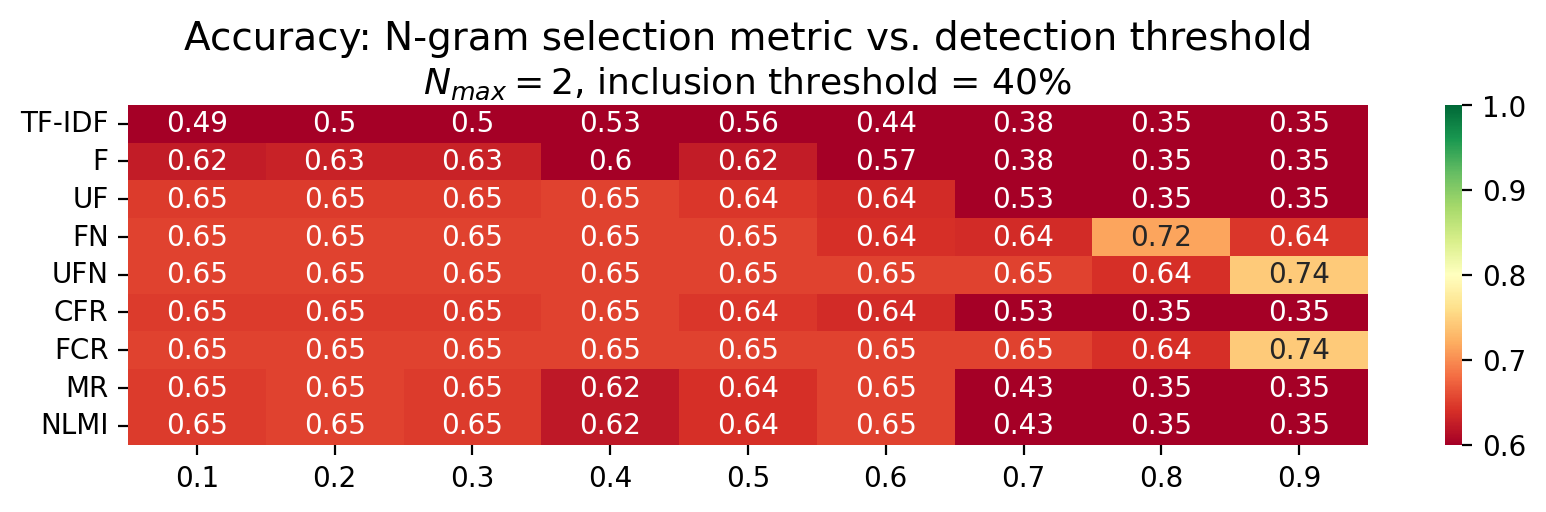

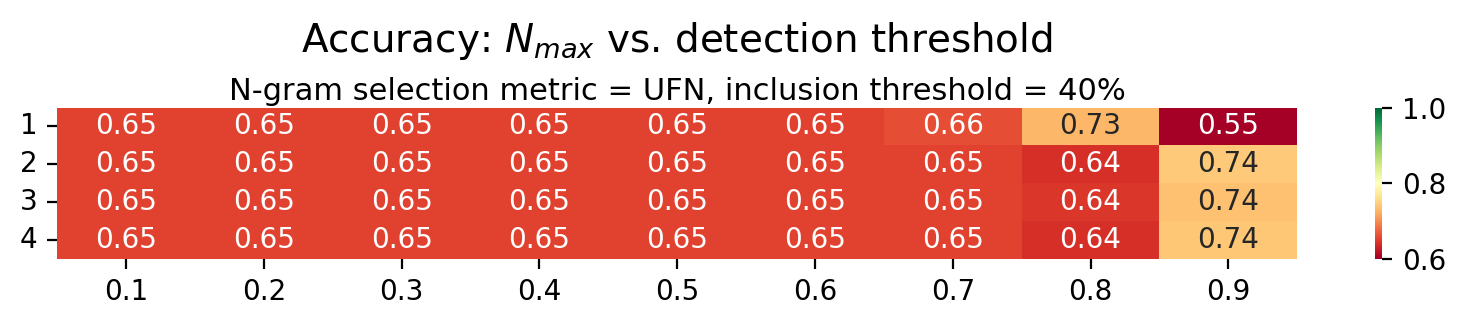

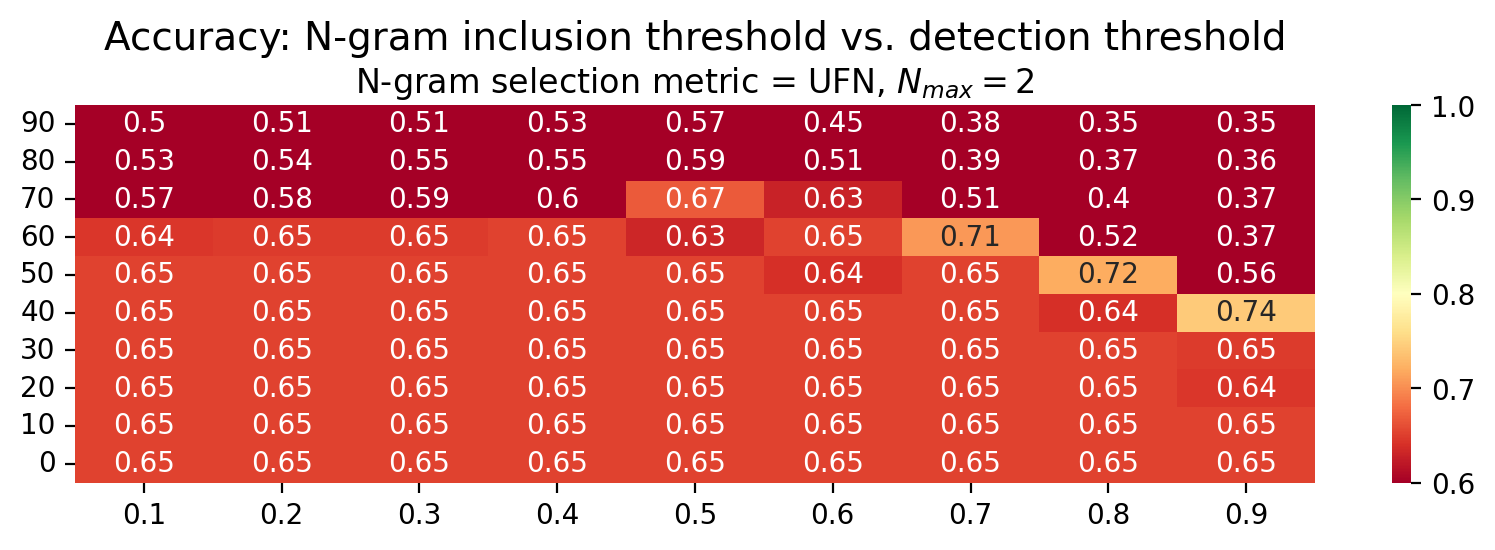

In [21]:
ngram_selection_metrics = ['TF-IDF','F','UF','FN','UFN','CFR','FCR','MR','NLMI']
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ngram_max_values = [1, 2, 3, 4]
ngram_inclusion_thresholds = [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]


# 1) N-gram selection metric - threshold
acc_analytics_threshold = np.zeros((len(ngram_selection_metrics), len(thresholds)))

for i, ngram_selection_metric in enumerate(ngram_selection_metrics):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any = analyse_dataset(ngram_selection_metric, best_nm, best_it, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any = analyse_dataset(ngram_selection_metric, best_nm, best_it, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any = analyse_dataset(ngram_selection_metric, best_nm, best_it, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3 if len(splits) == 3 else first_split_acc_any[key] 
    for key in first_split_acc_any
    }

    for j, threshold in enumerate(thresholds):
        acc_analytics_threshold[i, j] = average_acc_data[threshold]

matrix_plot(
    ngram_selection_metrics, thresholds, acc_analytics_threshold, 1.0,
    title="Accuracy: N-gram selection metric vs. detection threshold",
    subtitle="$N_{max}="+str(best_nm)+"$, inclusion threshold = "+str(best_it)+"%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)


# 2) ngram_max - threshold
acc_ngrammax_threshold = np.zeros((len(ngram_max_values), len(thresholds)))

for i, ngram_max in enumerate(ngram_max_values):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any = analyse_dataset(best_sm, ngram_max, best_it, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any = analyse_dataset(best_sm, ngram_max, best_it, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any = analyse_dataset(best_sm, ngram_max, best_it, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3 if len(splits) == 3 else first_split_acc_any[key] 
    for key in first_split_acc_any
    }

    for j, threshold in enumerate(thresholds):
        acc_ngrammax_threshold[i, j] = average_acc_data[threshold]

matrix_plot(
    ngram_max_values, thresholds, acc_ngrammax_threshold, 1.0,
    title="Accuracy: $N_{max}$ vs. detection threshold",
    subtitle="N-gram selection metric = "+best_sm+", inclusion threshold = "+str(best_it)+"%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=11,
    dpi=200, width=10
)


# 3) ngram_inclusion_threshold - threshold
acc_ngram_inclusion_threshold = np.zeros((len(ngram_inclusion_thresholds), len(thresholds)))

for i, ngram_inclusion_threshold in enumerate(ngram_inclusion_thresholds):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any = analyse_dataset(best_sm, best_nm, ngram_inclusion_threshold, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any = analyse_dataset(best_sm, best_nm, ngram_inclusion_threshold, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any = analyse_dataset(best_sm, best_nm, ngram_inclusion_threshold, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3 if len(splits) == 3 else first_split_acc_any[key]
    for key in first_split_acc_any
    }

    for j, threshold in enumerate(thresholds):
        acc_ngram_inclusion_threshold[i, j] = average_acc_data[threshold]

matrix_plot(
    ngram_inclusion_thresholds, thresholds, acc_ngram_inclusion_threshold, 1.0,
    title="Accuracy: N-gram inclusion threshold vs. detection threshold",
    subtitle="N-gram selection metric = "+best_sm+", $N_{max}="+str(best_nm)+"$",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=12,
    dpi=200, width=10
)

In [22]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)

'2 days, 13:44:15.656338'

### Our best model obtained through the optimal combination of hyper-parameters

In [23]:
for i, (train_df, test_df) in enumerate(splits, start=1):
    if i == 1:
        first_split_acc_any = analyse_dataset('FN', 3, 70, train_df, test_df, 'first_split', 'print_results')
    elif i == 2:
        second_split_acc_any = analyse_dataset('FN', 3, 70, train_df, test_df, 'second_split', 'print_results')
    elif i == 3:
        third_split_acc_any = analyse_dataset('FN', 3, 70, train_df, test_df, 'third_split', 'print_results')



N-gram selection metric: FN
N-gram max length: 3
N-gram inclusion threshold: 70
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.6047430830039525 0.7536945812807881
		 0.2 0.6086956521739131 0.7555555555555555
		 0.3 0.616600790513834 0.7593052109181142
		 0.4 0.6126482213438735 0.7525252525252526
		 0.5 0.6600790513833992 0.770053475935829
		 0.6 0.6482213438735178 0.7261538461538463
		 0.7 0.6245059288537549 0.6303501945525292
		 0.8 0.4743083003952569 0.3316582914572864
		 0.9 0.39920948616600793 0.14606741573033705
